# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# data Loading

In [114]:
data_path = "https://raw.githubusercontent.com/DriveMyScream/Multiple_Stock_Price_Prediction/main/XRP%20Historical%20Data%20-%20Investing.com%20India.csv"
dataset = pd.read_csv(data_path, parse_dates=['Date'])
dataset.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-05-15,0.42752,0.42520,0.42899,0.42161,196.21M,0.54%
1,2023-05-14,0.42522,0.42401,0.43144,0.42183,142.86M,0.29%
2,2023-05-13,0.42401,0.43048,0.43048,0.42362,145.07M,-1.51%
3,2023-05-12,0.43049,0.42064,0.44320,0.41665,562.85M,2.35%
4,2023-05-11,0.42063,0.43026,0.43042,0.41162,423.24M,-2.24%


In [115]:
dataset = dataset[::-1]
dataset.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1960,2018-01-01,2.05,1.98,2.09,1.81,120.74M,3.54%
1959,2018-01-02,2.19,2.05,2.21,1.89,201.99M,6.83%
1958,2018-01-03,2.73,2.19,2.85,2.15,387.51M,24.66%
1957,2018-01-04,2.73,2.73,3.29,2.58,438.91M,0.00%
1956,2018-01-05,2.51,2.73,3.05,2.24,381.02M,-8.06%


In [116]:
def parse_float(string_value):
  cleaned_string = string_value.replace(",", "")
  float_value = float(cleaned_string)
  return float_value

In [117]:
dataset['Open'] = dataset['Open'].astype(str).apply(parse_float)
dataset['High'] = dataset['High'].astype(str).apply(parse_float)
dataset['Low'] = dataset['Low'].astype(str).apply(parse_float)
dataset['Price'] = dataset['Price'].astype(str).apply(parse_float)

In [118]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 1960 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1961 non-null   datetime64[ns]
 1   Price     1961 non-null   float64       
 2   Open      1961 non-null   float64       
 3   High      1961 non-null   float64       
 4   Low       1961 non-null   float64       
 5   Vol.      1961 non-null   object        
 6   Change %  1961 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 107.4+ KB


In [119]:
dataset.describe()

,Price,Open,High,Low
count,1961.000000,1961.000000,1961.000000,1961.000000
mean,0.513268,0.513999,0.535611,0.489498
std,0.335413,0.336672,0.360285,0.309249
min,0.136040,0.135820,0.149240,0.105700
25%,0.295250,0.295260,0.305220,0.285030
50%,0.395270,0.395300,0.408310,0.381380
75%,0.633030,0.634660,0.657530,0.605020
max,2.780000,2.780000,3.290000,2.580000


In [120]:
dataset.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

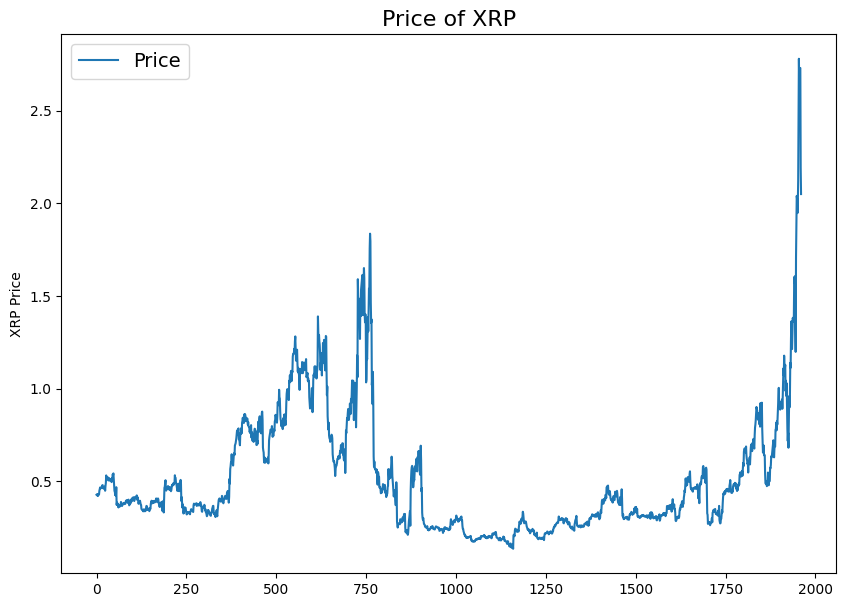

In [122]:
import matplotlib.pyplot as plt
dataset['Price'].plot(figsize=(10, 7))
plt.ylabel("XRP Price")
plt.title("Price of XRP", fontsize=16)
plt.legend(fontsize=14);

In [126]:
dataset.iloc[0]

Date        2018-01-01 00:00:00
Price                      2.05
Open                       1.98
High                       2.09
Low                        1.81
Vol.                    120.74M
Change %                  3.54%
Name: 1960, dtype: object

In [127]:
price_data = dataset['Price'].values
price_data

array([2.05   , 2.19   , 2.73   , ..., 0.42401, 0.42522, 0.42752])

In [128]:
price_data.shape

(1961,)

In [129]:
train_data, test_data = price_data[0:1800], price_data[1800:]

In [130]:
train_data.shape, test_data.shape

((1800,), (161,))

In [131]:
def windowed_dataset(series, time_step):
    dataX, dataY = [], []
    for i in range(len(series) - time_step - 1):
        a = series[i : i + time_step]  # Remove the indexing with ", 0"
        dataX.append(a)
        dataY.append(series[i + time_step])
        
    return np.array(dataX), np.array(dataY)

In [132]:
X_train, y_train = windowed_dataset(train_data, time_step=7)
X_test, y_test = windowed_dataset(test_data, time_step=7)

In [133]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1792, 7), (1792,), (153, 7), (153,))

In [134]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape) 
print(X_test.shape)

(1792, 7, 1)
(153, 7, 1)


In [135]:
X_train[0]

array([[2.05],
       [2.19],
       [2.73],
       [2.73],
       [2.51],
       [2.65],
       [2.78]])

In [136]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [137]:
# Create the LSTM model
model = models.Sequential()

model.add(layers.Input(shape = (7, 1), dtype=tf.float32))
# Add the Normalization layer
model.add(layers.Normalization())

# Specify the mean and variance for normalization
model.layers[0].adapt(X_train)

model.add(layers.LSTM(units=100, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.4))

model.add(layers.LSTM(units=10, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=1))

In [138]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 7, 1)             3         
 ion)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 7, 100)            40800     
                                                                 
 dropout_9 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_10 (LSTM)              (None, 7, 50)             30200     
                                                                 
 dropout_10 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 10)                2440      
                                                      

In [139]:
model.compile(optimizer = 'adamax', loss = 'mse', metrics = 'mae')

In [140]:
# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/30
51/51 [==============================] - 7s 32ms/step - loss: 0.3175 - mae: 0.4363 - val_loss: 0.0265 - val_mae: 0.1338
Epoch 2/30
51/51 [==============================] - 1s 21ms/step - loss: 0.2027 - mae: 0.3440 - val_loss: 0.0184 - val_mae: 0.1150
Epoch 3/30
51/51 [==============================] - 1s 28ms/step - loss: 0.0894 - mae: 0.2274 - val_loss: 0.0044 - val_mae: 0.0497
Epoch 4/30
51/51 [==============================] - 2s 40ms/step - loss: 0.1412 - mae: 0.1938 - val_loss: 0.0072 - val_mae: 0.0709
Epoch 5/30
51/51 [==============================] - 2s 44ms/step - loss: 0.0790 - mae: 0.1760 - val_loss: 0.0083 - val_mae: 0.0805
Epoch 6/30
51/51 [==============================] - 2s 30ms/step - loss: 0.0645 - mae: 0.1632 - val_loss: 0.0079 - val_mae: 0.0797
Epoch 7/30
51/51 [==============================] - 1s 20ms/step - loss: 0.0654 - mae: 0.1567 - val_loss: 0.0073 - val_mae: 0.0769
Epoch 8/30
51/51 [==============================] - 1s 21ms/step - loss: 0.0624 - m

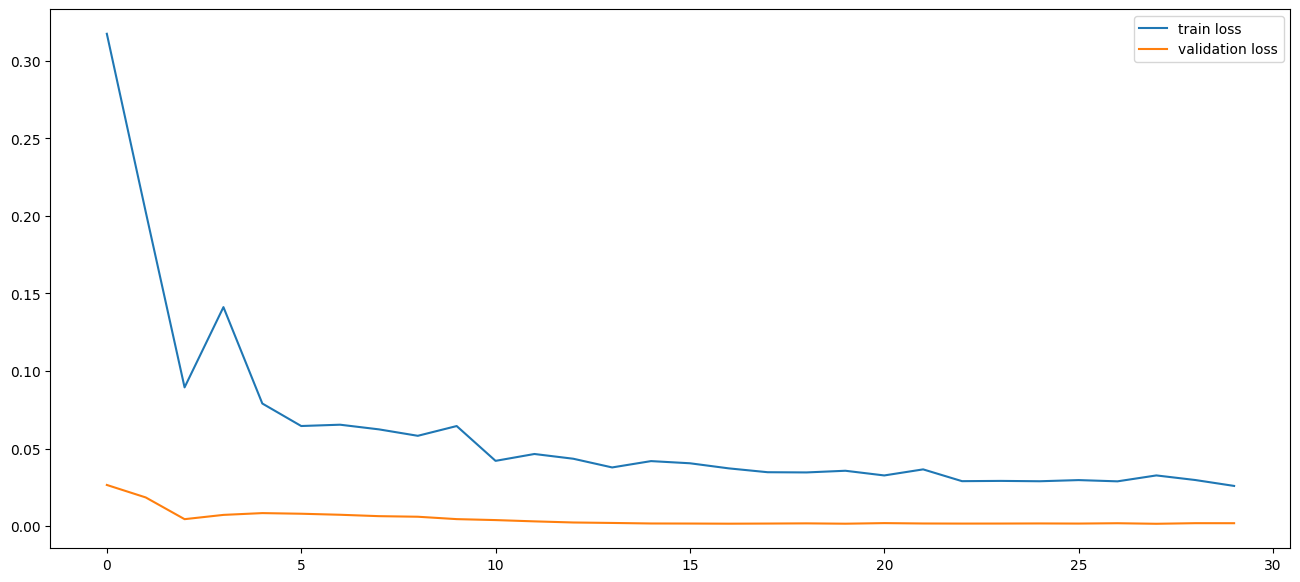

In [141]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend();

In [142]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


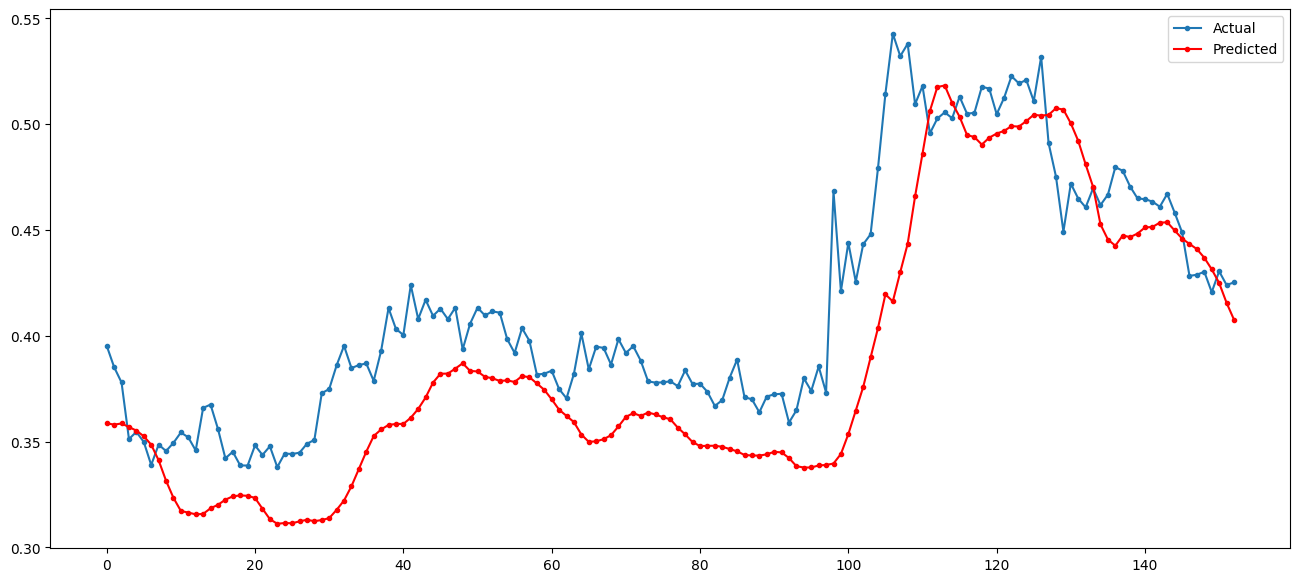

In [143]:
plt.figure(figsize=(16,7))
plt.plot(y_test.flatten(), marker='.', label="Actual")
plt.plot(test_predict.flatten(), 'r', marker='.', label="Predicted")
plt.legend();

In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(y_train, train_predict))
test_RMSE = np.sqrt(mean_squared_error(y_test, test_predict))
train_MAE = np.sqrt(mean_absolute_error(y_train, train_predict))
test_MAE = np.sqrt(mean_absolute_error(y_test, test_predict))


print(f"Train RMSE: {train_RMSE}")
print(f"Train MAE: {train_MAE}")

print(f"Test RMSE: {test_RMSE}")
print(f"Test MAE: {test_MAE}")

Train RMSE: 0.09327241169456443
Train MAE: 0.23191330407306454
Test RMSE: 0.03788276717048237
Test MAE: 0.17477370610014561


# at Inference

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [145]:
model.save("XRP_Price_Prediction")

In [146]:
model = tf.keras.saving.load_model("/content/XRP_Price_Prediction")

In [147]:
%cp -av /content/XRP_Price_Prediction /content/drive/MyDrive/Multiple_Stock_Price_Prediction

'/content/XRP_Price_Prediction' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction'
'/content/XRP_Price_Prediction/variables' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction/variables'
'/content/XRP_Price_Prediction/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction/variables/variables.data-00000-of-00001'
'/content/XRP_Price_Prediction/variables/variables.index' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction/variables/variables.index'
'/content/XRP_Price_Prediction/assets' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction/assets'
'/content/XRP_Price_Prediction/fingerprint.pb' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction/fingerprint.pb'
'/content/XRP_Price_Prediction/saved_model.pb' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/XRP_Price_Prediction

In [148]:
X_test[0].shape

(7, 1)

In [149]:
prices = np.array([[2.05],
       [2.19],
       [2.73],
       [2.73],
       [2.51],
       [2.65],
       [2.78]])
prices = prices.reshape(1, -1, 1)
prediction_price = model.predict(prices)
prediction_price = prediction_price[0][0]
print("Prediction Price: ", prediction_price)

1/1 [==============================] - 0s 451ms/step
Prediction Price:  1.9422054


In [150]:
print("Predicted XRP Price: {0:.2f} ".format(prediction_price))

Predicted XRP Price: 1.94 
